# PyTorch Convolutional Neural Network (CNN) With CIFAR-10 Color Image Dataset

In this example, we demonstrate how to train a CNN model (aka ConvNet)  to classify images from the CIFAR-10 dataset. With the nature of CNN can handle spatial data of images and video, the RGB-color images  of CIFAR-10 can be directly use as input to the model.

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/cnn_cifar10.png'>


The CIFAR-10 dataset is a widely used collection of images that is commonly used to train machine learning and computer vision algorithms

- It consists of 60,000 32x32 color images in 10 different classes
- Each class contains 6,000 images, with 5,000 images for training and 1,000 images for testing
- The 10 different classes in the CIFAR-10 dataset represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

The CIFAR-10 dataset can be split into training set, validation set, and test set in various ways. In this example, the way is to use 45,000 images for training, 5,000 images for validation, and 10,000 images for testing.

<!-- <img src='https://corochann.com/wp-content/uploads/2021/09/cifar10_plot.png'> -->


References:

- https://github.com/nestorojeda/CIFAR-10-CNN


In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.1.0+cu121
Device: cuda


In [ ]:
# Set seed for reproducibility
seed = 4016
torch.manual_seed(seed)

# Download CIFAR10 Dataset

This code snippet helps us download the CIFAR-10 dataset, which is a popular dataset used for training and evaluating deep learning models. The dataset is divided into a training set and a test set.

In deep learning, it's common to split the dataset into training, validation, and test sets. However, in this particular example, the validation set is not used. Instead, we only use the training set to train our model. The training set consists of 50,000 samples, and we use these samples to teach our model how to recognize and classify images.

**During and after training, the model's performance is evaluated by the test set with 10,000 samples. The test set contains a separate set of samples that were not used to update the model's parameters during the training.** We use this test set to assess how well our trained model can generalize to new, unseen data.

By creating DataLoaders, we can easily handle the downloading and loading of the training and test sets, making it convenient for us to train our deep learning model on the CIFAR-10 dataset.


In [ ]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

# Create the CIFAR10dataset for the training set with 50,000 images
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Create the CIFAR10 dataset for the test set with 10,000 images (It is also used as validation set during the training)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define the classes for the CIFAR-10 dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:04<00:00, 37715582.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize image for each class

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

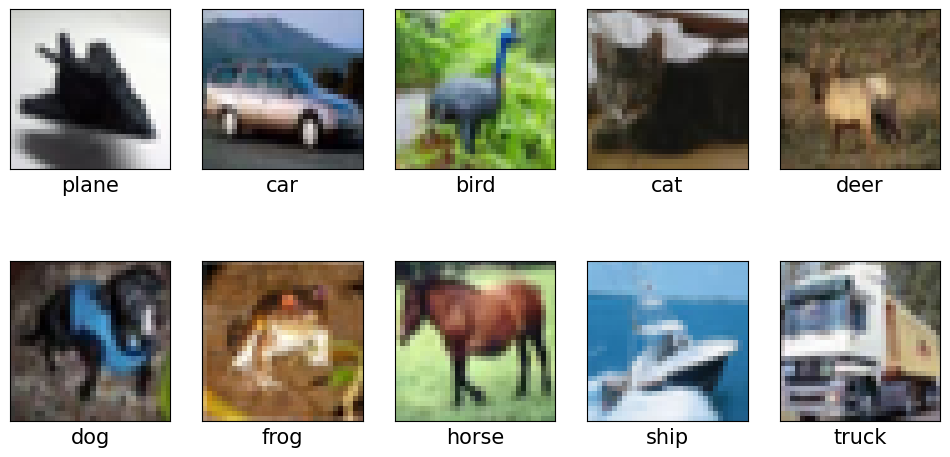

In [ ]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define the CNN Architecture

The following code defines a class called CNN_Model which inherits from nn.Module. The network has 3 fully-connected layers:

- In the first line, we use the "Conv2d" module to implement a convolutional neural network. The first parameter, 3, indicates that the input image is colored and in RGB format. If it were a grayscale image, we would use 1 instead.

- The number 32 represents the initial output channels, and in the next Conv2d layer, we would use 32 as the input channels and 64 as the output channels.

- The third parameter in the first line is the kernel size, which determines the size of the filters used. The last parameter is for padding, which helps maintain the spatial dimensions of the input.

After each Conv2d layer, we apply an activation function, specifically the Rectified Linear Unit (ReLU). Following two Conv2d layers, we perform a max-pooling operation with a 2x2 size. The resulting values are then batch normalized to ensure stability and avoid internal covariate shift. These operations are repeated with additional layers to make the network deeper and reduce the size of the data. Finally, we flatten the layer to create a linear layer that maps the values to 10 outputs. The probability of each neuron in these 10 outputs determines the class to which a particular image belongs, with the highest probability indicating the predicted class.

In [ ]:
# Define the CNN Model

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(64*8*8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.bn1(self.pool(F.relu(self.conv1(x))))
    x = self.bn2(self.pool(F.relu(self.conv2(x))))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [ ]:
model = CNN()

In [ ]:
summary(model=model, input_size=(1, 3, 32, 32), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

## Training the Network

The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables
Forward pass: compute predicted outputs by passing inputs to the model
Calculate the loss
Backward pass: compute gradient of the loss with respect to model parameters
Perform a single optimization step (parameter update)
Update average training loss
The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
# Specify Loss/Cost function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify Learning Rate Scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

In [ ]:
EPOCHS = 100

loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_test, acc_hist_test = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(batch)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)  # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_test = 0.0
        correct_test = 0

        # Validation loop
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            loss_test += loss.item()

        avg_loss_test = loss_test / len(test_set)  # Average validation loss for the epoch
        avg_acc_test = correct_test / len(test_set)  # Average validation accuracy for the epoch
        loss_hist_test.append(avg_loss_test)
        acc_hist_test.append(avg_acc_test)

    model.train()  # Set the model back to training mode
#     scheduler.step(avg_loss_val) # Check the scheduler for updating the learning rate

    # Save the model at the end of each epoch
    with open("Models/lenet5_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Test Loss: {:.3f}".format(avg_loss_test * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Test Accuracy: {:.2f}%".format(avg_acc_test * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

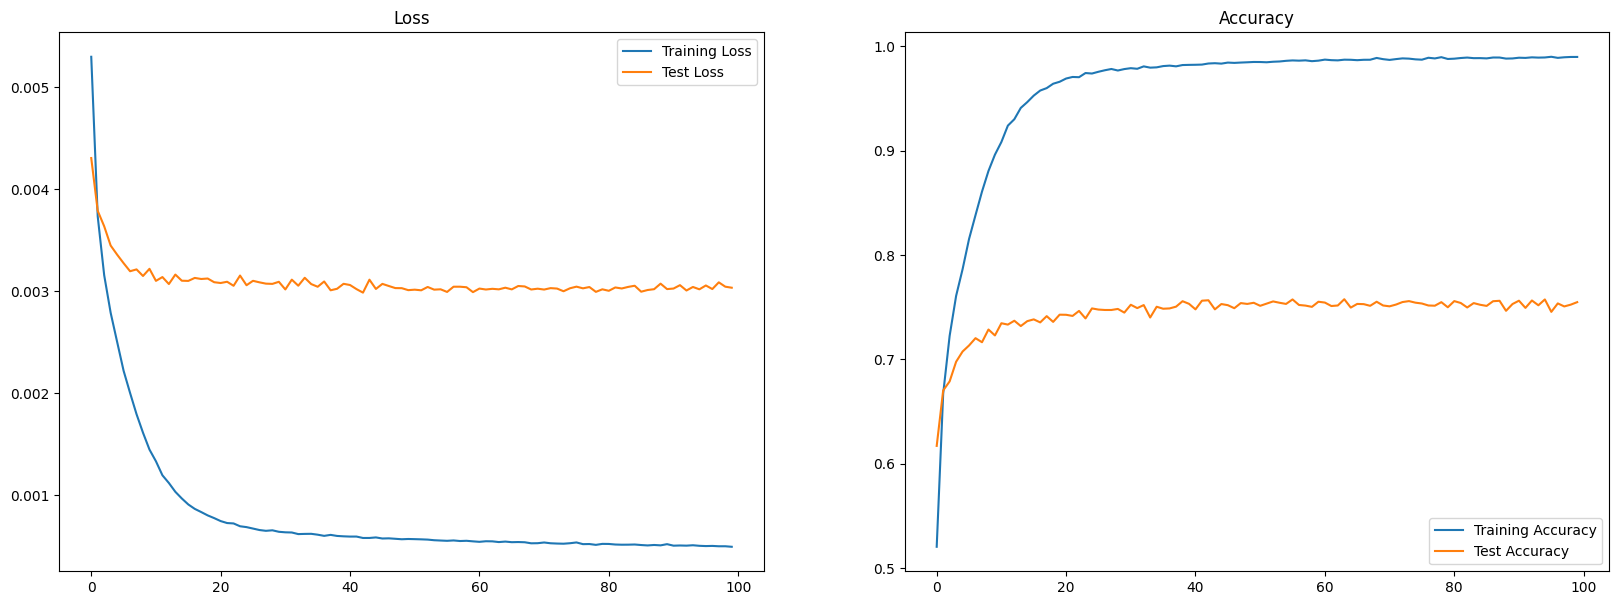

In [ ]:
plots=[(loss_hist,loss_hist_test),(acc_hist,acc_hist_test)]
plt_labels=[("Training Loss","Test Loss"),("Training Accuracy","Test Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

## Save the trained model

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

# Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_test)
best_epoch = acc_hist_test.index(best_acc)+1

print("Best accuracy on test set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/lenet5_model_{best_epoch}.pth","rb") as f:
    model=pickle.load(f)


# Recalculate Test Set Accuracy

In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


# Display the Test Set Accuracy

In [ ]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

Test Loss: 0.0030184810042381285
Test Accuracy on the 10000 test images: 75.76%


# Display the Confusion Matrix

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,827,11,44,13,13,5,6,12,43,26
car,39,827,9,6,3,4,4,7,16,85
bird,56,4,678,45,74,39,40,45,5,14
cat,21,8,80,539,53,170,61,39,13,16
deer,20,1,76,50,723,24,38,56,9,3
dog,17,4,45,144,49,656,22,47,7,9
frog,4,4,42,55,42,20,820,5,5,3
horse,13,2,34,33,40,42,4,820,1,11
ship,71,31,12,9,3,2,6,7,832,27
truck,42,53,6,12,3,9,4,8,9,854


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,plane,0.783886,0.827000,0.745045,1110.0000
1,car,0.850386,0.827000,0.875132,945.0000
2,bird,0.669299,0.678000,0.660819,1026.0000
3,cat,0.565582,0.539000,0.594923,906.0000
4,deer,0.721917,0.723000,0.720837,1003.0000
5,dog,0.665652,0.656000,0.675592,971.0000
6,frog,0.817955,0.820000,0.815920,1005.0000
7,horse,0.801564,0.820000,0.783939,1046.0000
8,ship,0.857732,0.832000,0.885106,940.0000
9,truck,0.833984,0.854000,0.814885,1048.0000
